In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from data_generation import Sinusoids, apply_ft, apply_noise

In [8]:
# Define array sizes and data sizes here 
#Size of x, y arrays created
ARRAY_SIZE = 1000

#Total number of functions to generate both noisy and clean
DATA_SIZE = 100

In [9]:
# Setup folder for data

# Get current working directory
cwd = os.getcwd()

# Set data folder location
data_loc = os.path.join(cwd, "Data")

# Search for data folder
if "Data" not in os.listdir(cwd):

    # Create data folder if not found
    os.makedirs(data_loc)

In [10]:
sinusoids = Sinusoids(DATA_SIZE, ARRAY_SIZE)
data_set = sinusoids.create_data()

In [11]:
# Create n clean data sets with random period
x_vals = data_set["X"]
y_vals = data_set["Y"]
classification = data_set["Classification"]

# Create a noisy data set and classifier list
y_vals_noise = apply_noise(x_vals, ARRAY_SIZE)
classification_noise = ["Noisy" for i in range(len(x_vals))]

data_set["X"] = x_vals + x_vals
data_set["Y"] = y_vals + y_vals_noise
data_set["Classification"] = classification + classification_noise

In [12]:
# Create a pandas dataframe and export to the data location provided above
data = pd.DataFrame(data_set)
data.to_csv(f"{data_loc}/data.csv")

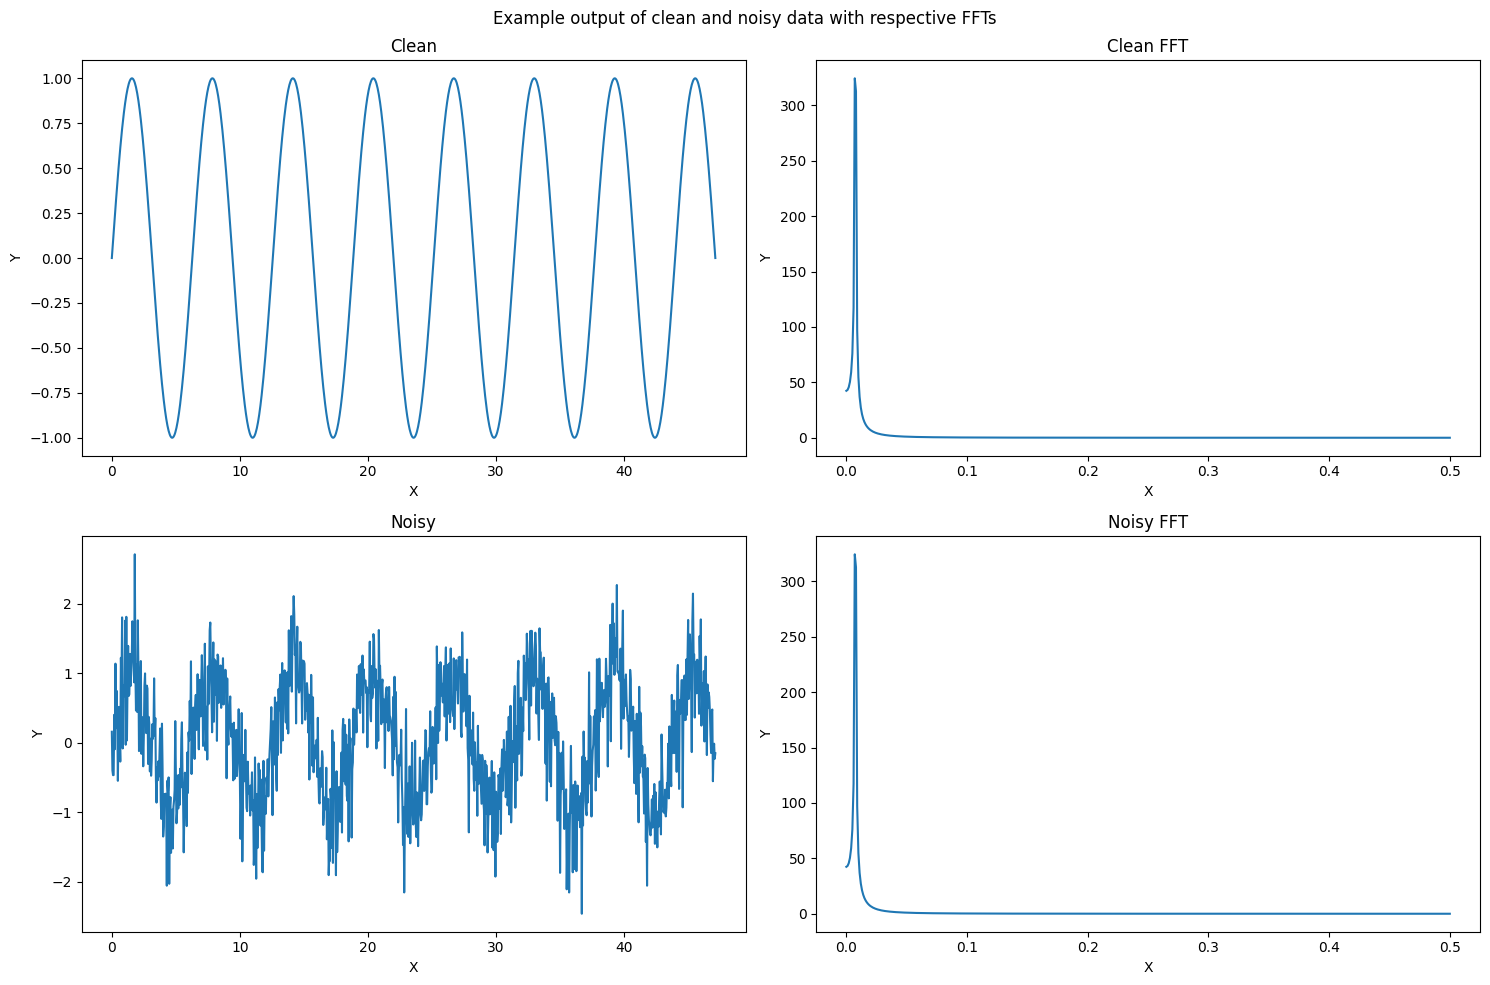

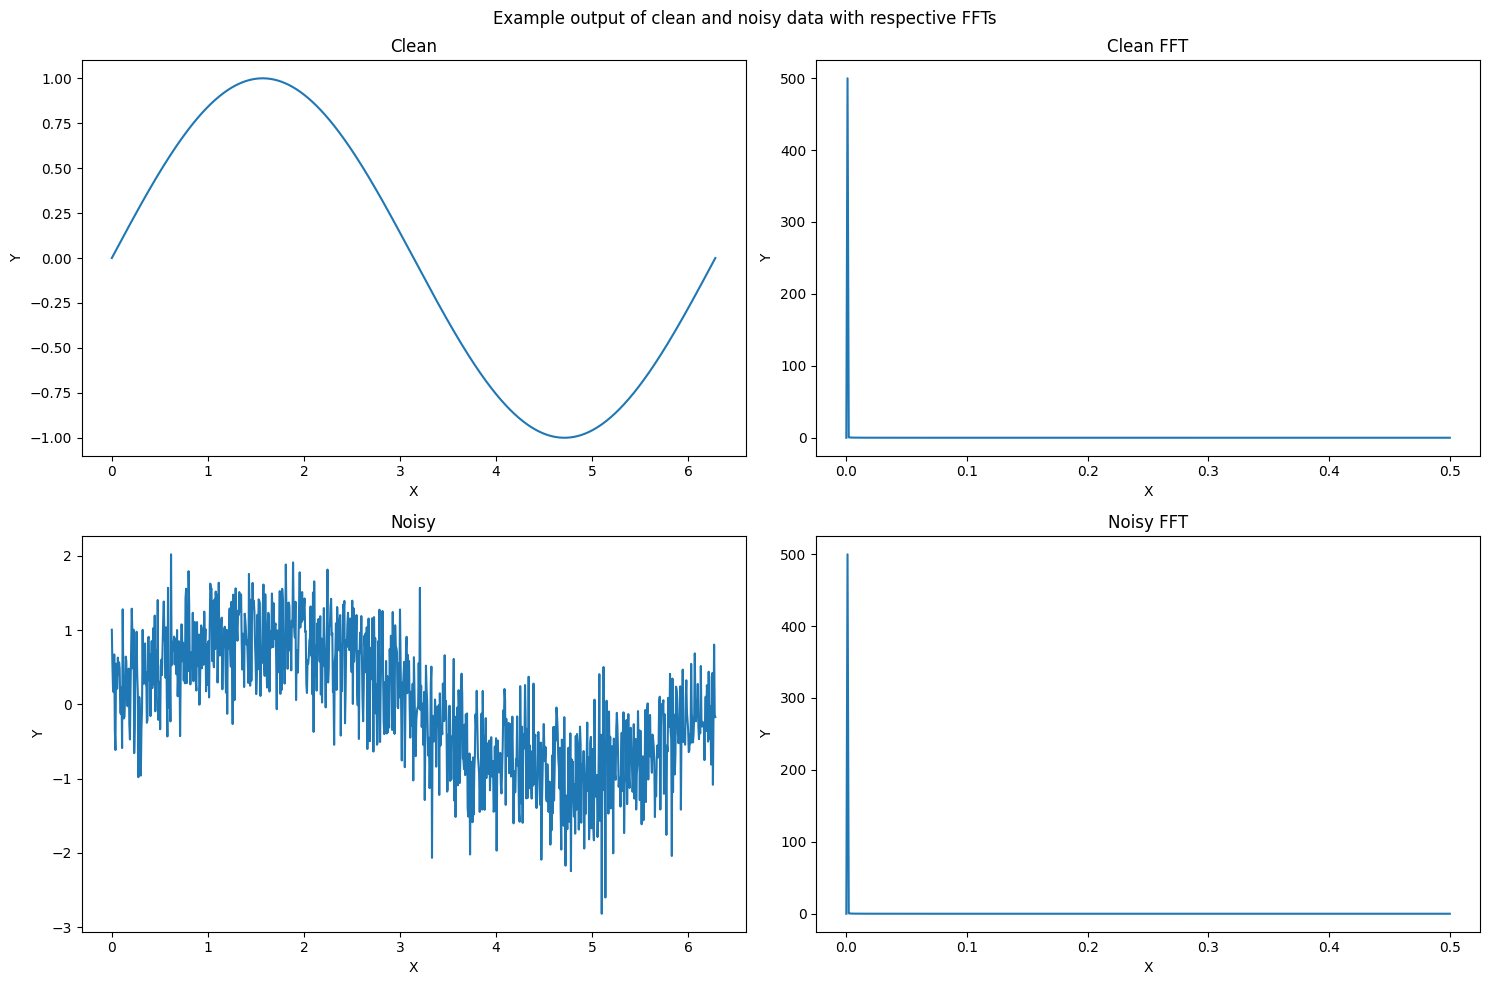

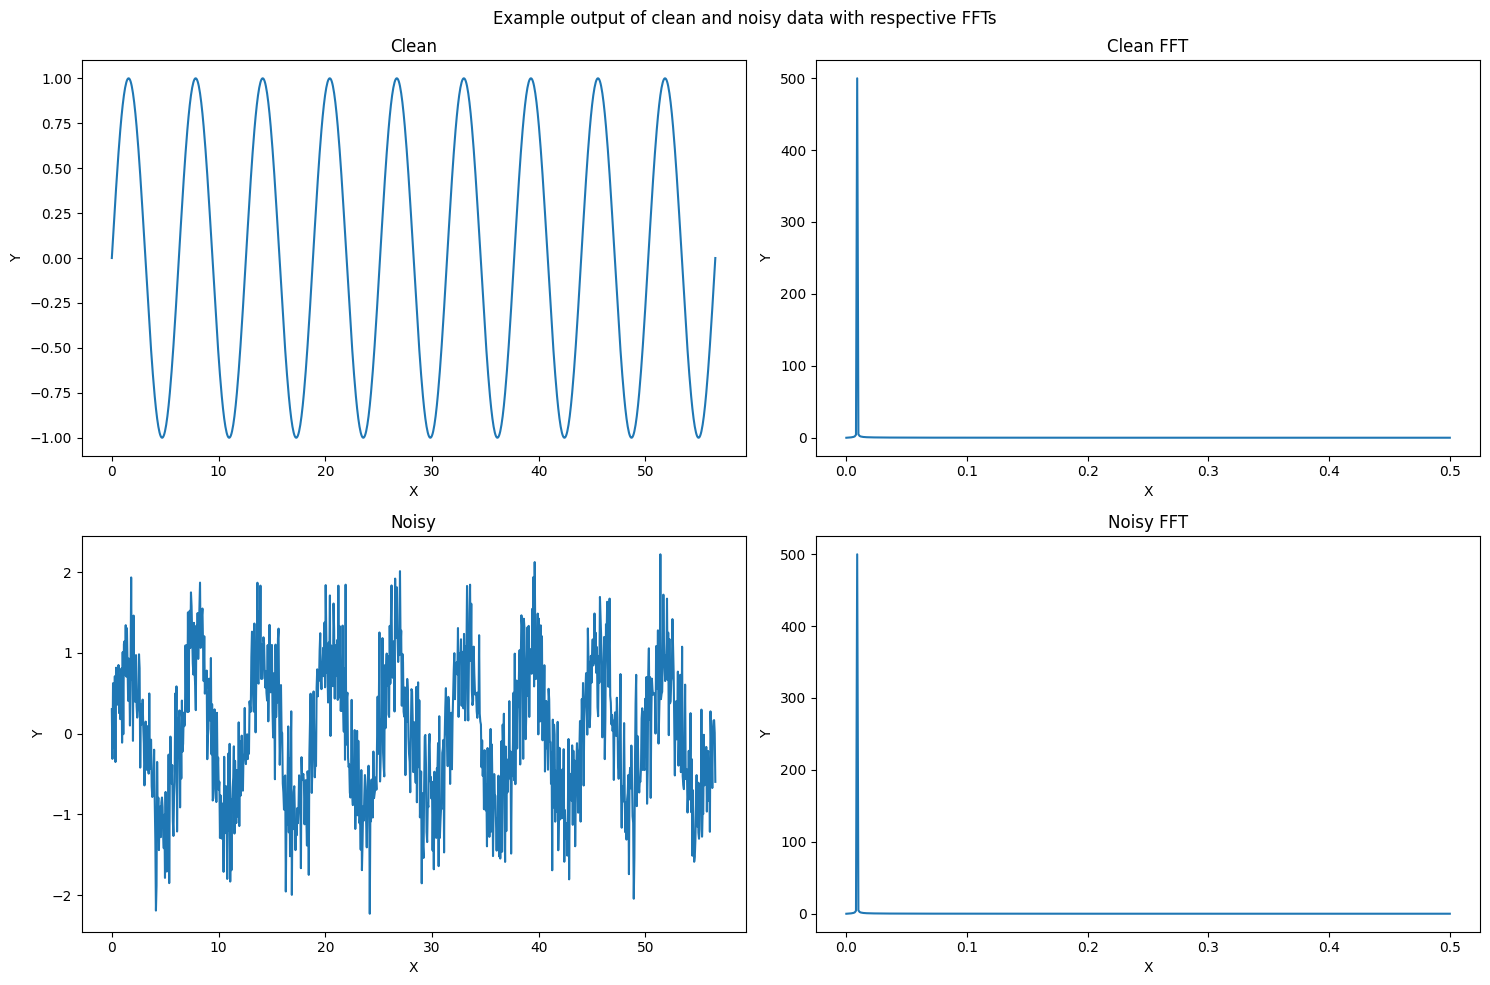

In [17]:
# Load each each column respectively
y_data = np.asarray(data["Y"])
x_data = np.asarray(data["X"])

# Create a random test index list
index = [np.random.randint(1, DATA_SIZE) for x in range(3)]

# Loop over the index list and plot the respective noisy and clean functions
for i in index:
    plt.figure(figsize=[15,10])
    plt.suptitle("Example output of clean and noisy data with respective FFTs")
    plt.subplot(221)
    plt.title("Clean")
    plt.plot(x_data[i], y_data[i])
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.subplot(222)
    plt.title("Clean FFT")
    plt.plot(np.fft.rfftfreq(len(y_data[i])), apply_ft(y_data[i]))
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.subplot(223)
    plt.title("Noisy")
    plt.plot(x_data[i+DATA_SIZE], y_data[i+DATA_SIZE])
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.subplot(224)
    plt.title("Noisy FFT")
    plt.plot(np.fft.rfftfreq(len(y_data[i+DATA_SIZE])), apply_ft(y_data[i]))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.savefig(f"Data/Example_output{i}.png")
    plt.show()

In [14]:
# Import the required modules from sklearn, for embedding NCA is used, KNN is used as the classifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

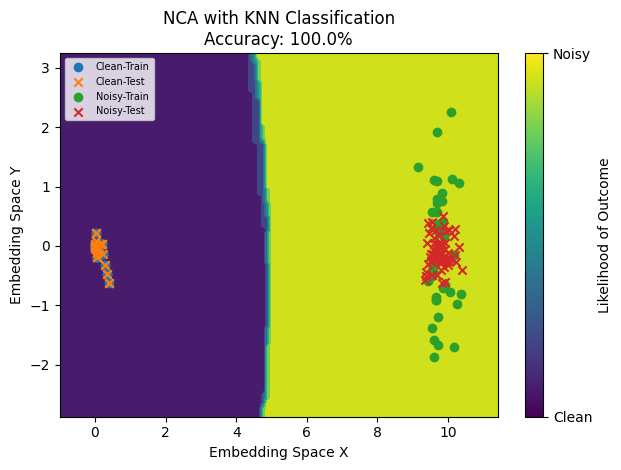

In [15]:
# Separate data into features and labels for classification
features = np.asarray([apply_ft(y_data[i]) for i in range(len(x_data))])
labels = data["Classification"]

# Split the data set
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.5)

# Condenses scaling operations into an embedding process
emb = make_pipeline(
    MinMaxScaler(),  NeighborhoodComponentsAnalysis(n_components=2))

# Fit the embedding to the training data
emb.fit(X_train, y_train)

# Apply the embedding across all data sets
x_train_transform = emb.transform(X_train)
x_test_transform = emb.transform(X_test)
embedded_features = np.append(x_train_transform, x_test_transform, axis=0)

# Setup classifier and fit to embedded training set
clf = KNeighborsClassifier(n_neighbors=4)
clf.fit(x_train_transform, y_train)
accuracy = clf.score(x_test_transform, y_test)
# Plot the result
disp = DecisionBoundaryDisplay.from_estimator(
    clf, embedded_features, response_method="predict_proba")
outcomes = ["Clean", "Noisy"]
for outcome in outcomes:
    x_train_outcome = x_train_transform[[y == outcome for y in y_train]]
    ax1 = disp.ax_.scatter(*x_train_outcome.T, label=f"{outcome}-Train")
    x_test_outcome = x_test_transform[[y == outcome for y in y_test]]
    ax2 = disp.ax_.scatter(
        *x_test_outcome.T, label=f"{outcome}-Test", marker="x")
    disp.ax_.legend(fontsize="7")
    disp.ax_.set_xlabel("Embedding Space X")
    disp.ax_.set_ylabel("Embedding Space Y")
cbar = disp.figure_.colorbar(ax1, label="Likelihood of Outcome", ticks=[0, 1])
cbar.set_ticklabels(outcomes)
plt.title(f"NCA with KNN Classification\nAccuracy: {accuracy*100}%")
plt.tight_layout()
plt.show()

In [69]:
#Create new unseen dataset
x_new = np.linspace(0, 2*np.pi, ARRAY_SIZE)
y_new_noisy = np.abs(np.fft.rfft(np.sin(x_new) + np.random.normal(0, .5, ARRAY_SIZE)))
y_new_clean = np.abs(np.fft.rfft(2*np.sin(x_new) + 8*np.cos(x_new)))

noisy_result = clf.predict(emb.transform(y_new_noisy.reshape(1, -1)))
clean_result = clf.predict(emb.transform(y_new_clean.reshape(1, -1)))

print(f"Clean: {clean_result}")
print(f"Noisy: {noisy_result}")


Clean: ['Clean']
Noisy: ['Noisy']
